Creating a model to Explore/Predict the NBA Most Valuable Players Award Winner


In [1]:
#IMPORTS
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 

### Get a Dataset and Define a Goal
I've always had a keen interest in sports. In fact, the main reason why I opted to enroll in ASU as a Computer Science major was to one day work as a sports analyst working profoundly in statistics and data analytics. Which is why, given the oppotunity to select my own topic for this project, I decided to pick a topic in Basketball (NBA). The goal of this project is to predict a season's NBA Most Valuable Player (MVP) award based on a number of features that gauge a player's performance. <br>

The datasets which I've selected from Kaggle is a large collection of historical player statistics dating from the very start of the NBA (manually) narrowed down to the last 20 years. As well, the remaining data was filtered down further to remove NaN values and inconsistencies.

In [2]:
#Download latest version
path = kagglehub.dataset_download("sumitrodatta/nba-aba-baa-stats")

#Import csv's from Kaggle
player_per_game_df = pd.read_csv(f'{path}/Player Per Game.csv')
player_award_shares_df = pd.read_csv(f"{path}/Player Award Shares.csv")
advanced_stats_df = pd.read_csv(f"{path}/Advanced.csv")

#Filter for MVP winners
mvp_data = player_award_shares_df[(player_award_shares_df['award'] == 'nba mvp') & (player_award_shares_df['winner'] == True)]
mvp_last_20_years = mvp_data[mvp_data['season'] >= 2004]

#Merge Award stats with Advanced stats with per game stats
merged_data_1 = pd.merge(mvp_last_20_years, player_per_game_df, how='inner', on=['season', 'player_id'])
merged_data_final = pd.merge(merged_data_1, advanced_stats_df, how='inner', on=['season', 'player_id'])

#Filter player_per_game data for last 20 years w/o MVP winners
non_mvp_players = player_per_game_df[player_per_game_df['season'] >= 2004]
non_mvp_players = non_mvp_players[~non_mvp_players['player_id'].isin(mvp_last_20_years['player_id'])]

#Merge non-MVP data with advanced stats
non_mvp_data = pd.merge(non_mvp_players, advanced_stats_df, how='inner', on=['season', 'player_id'])

#Assign 'winner' column to 0 for non-MVP players
non_mvp_data['winner'] = 0

#Put it all together
combined_data = pd.concat([merged_data_final, non_mvp_data])
combined_data = combined_data[combined_data['season'] >= 2004]

#Handle missing values (NaN) and infinite values (inf)
combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_columns = combined_data.select_dtypes(include=[np.number]).columns
combined_data[numeric_columns] = combined_data[numeric_columns].fillna(combined_data[numeric_columns].mean())


### Perform a Brief Exploratory Data Analysis and Features chosen
In this brief expliratiry data analysis, I've decided to plot the relationships depicted between the MVP award winners and various features I deemed historically relevant to the criteria necessary to win said award. Those features are: \
1\. The statsheet giants - Points per Game, Assists per Game, (total) Rebounds per game \
2\. Win shares (advanced stat derived from an individuals' contribution to the team's success in a game) \
3\. Usage Percentage (amount of time player is "in use" or being a part of an active play) \
4\. Box Score Plus/Minus (metric showing how much points over/under the opponent's score the player's team achieved while that player is on the court). \
5\. Value Over Replacement Player (a statistic used in basketball to measure a player's overall contributions to their team, when compared to an average "replacement" player at the same position)

In [3]:
#Most important features (historically) for this particular award
features = ['pts_per_game', 'ast_per_game', 'trb_per_game', 'ws', 'usg_percent', 'bpm', 'vorp']
target = 'winner'

c:\Users\Rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

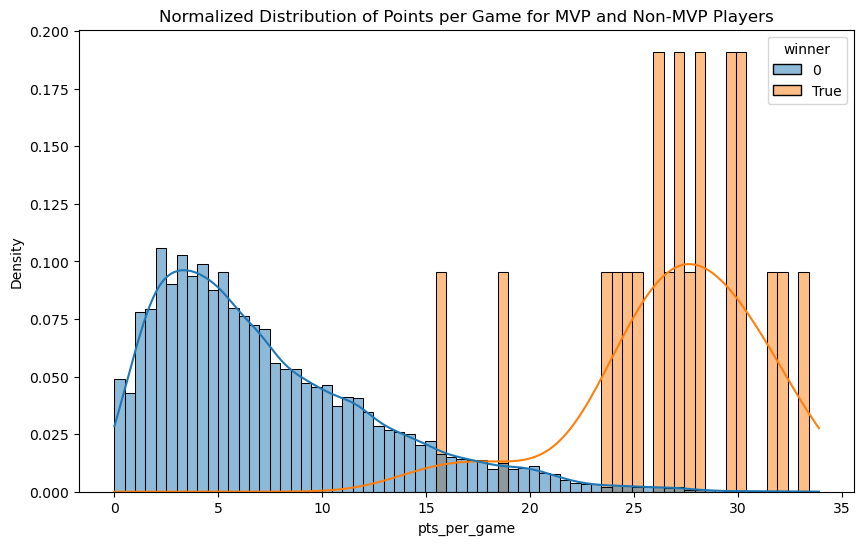

In [4]:
#Histograms of points per game for MVP and non-MVP players
# Normalize the data so both MVP and Non-MVP distributions are visible
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_data, x='pts_per_game', hue='winner', kde=True, stat='density', common_norm=False)
plt.title('Normalized Distribution of Points per Game for MVP and Non-MVP Players')
plt.show()

import warnings
warnings.filterwarnings("ignore")

There's a notion that exists claiming that Points Scored (points per game) is the most important factor in boosting a player's odds in winning the MVP award. The above normalized distribtuon graph does show some evidence of that as the MVP winners are the players scoring hefty points night in and night out. That said, the other stats mentioned previously also play a big role which I'll be showing below:

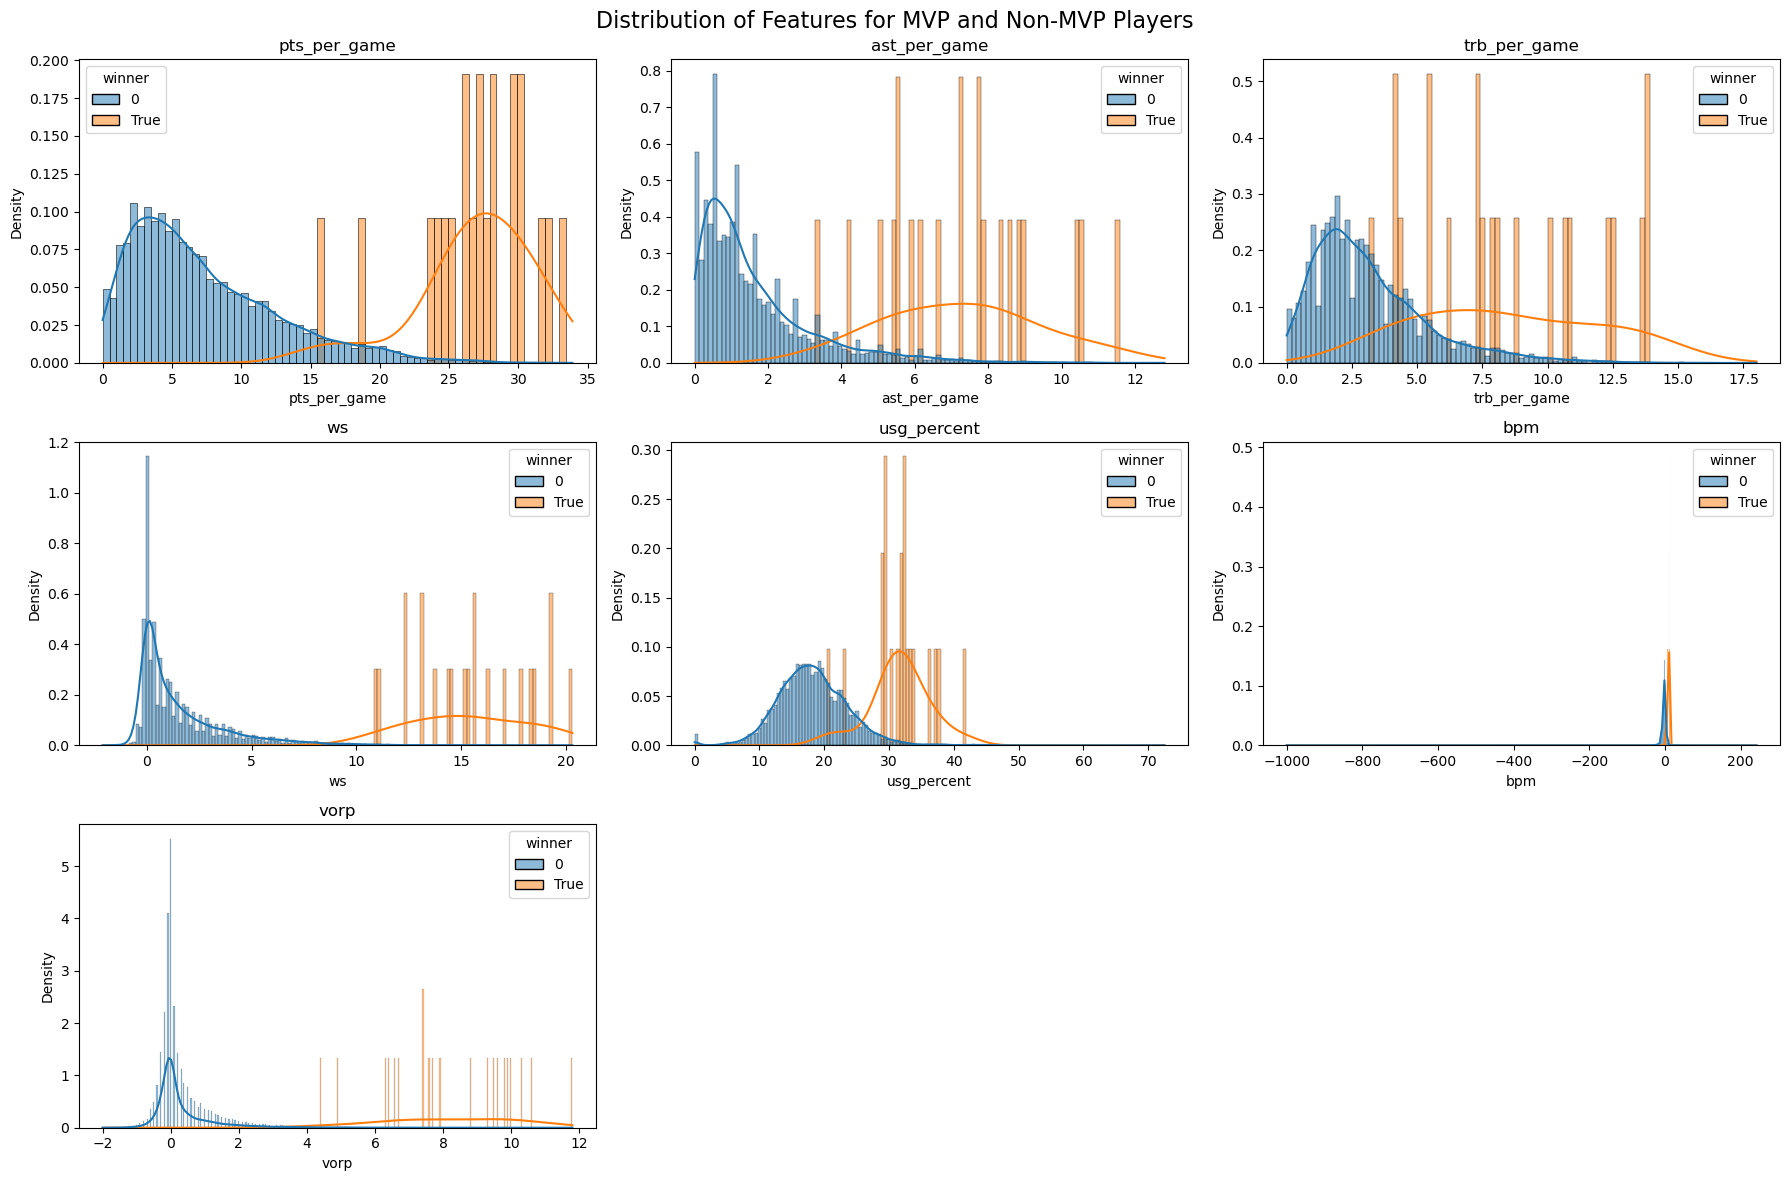

In [5]:
rows = (len(features) + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(18, 12))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.histplot(data=combined_data, x=feature, hue='winner', kde=True, stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'{feature}', fontsize=12)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('Distribution of Features for MVP and Non-MVP Players', fontsize=16)
plt.tight_layout()
plt.show()

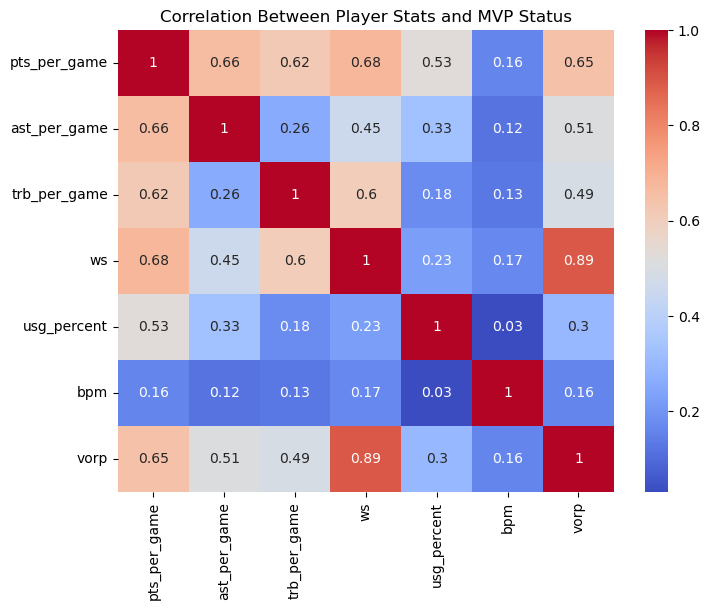

In [6]:
# Correlation matrix of key features
correlation = combined_data[features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title('Correlation Between Player Stats and MVP Status')
plt.show()


I picked a heatmap since it holistically shows you every stats' relationship for MVP winners. While 'Points Per Game' is moderately correlated with (nearly) every other statistic, it's clear here that advanced stats like 'Win Shares (ws)' and 'Value over Replacement Players (vorp)' have the highest likelihood in finding the MVP when paired together. The heatmap also shows that I may have overvalued 'Box Plus/Minus (bpm)' and 'Usage Percentage (usg_percent)' a bit as they seem to have lower correlations showing that players that "have the ball most" or "are on the court most" are always necessarily the players most deserving of the MVP award.

### Split Your Data into Training and Testing Sets
The data was split into training (80%) and testing (20%) sets using the train_test_split function from Scikit-learn and the random seed (state of 42) was used. This ensures that the model can be trained on one portion of the data while being evaluated on unseen data to simulate real-world performance.

In [7]:
#Prepare the feature matrix (X) and target vector (y)
X_combined = combined_data[features]
y_combined = combined_data[target].astype(int)

#Handle missing values by filling them with the mean of each feature
X_combined_filled = X_combined.fillna(X_combined.mean())

#Split the data into training and test sets
X_train_combined_filled, X_test_combined_filled, y_train_combined_filled, y_test_combined_filled = train_test_split(
    X_combined_filled, y_combined, test_size=0.2, random_state=42)


### Rescale Data
Rescaling was done on the data to help prevent any potential data leakage.

In [8]:
#Rescaled using Standard Scaler
scaler = StandardScaler()

#Fit/Tranform
X_train_combined_scaled = scaler.fit_transform(X_train_combined_filled)
X_test_combined_scaled = scaler.transform(X_test_combined_filled)

### Train/Tune Candidate Models
The two model types I'll be training are Logistic Regression and Decision Tree Models. I decided on setting the maximum tree depth to 2 to negate overfitting (hyperparameter tuning) as that's what produced the highest Cross-Validation accuracy (via GridSearchCV) as seen in the plot. <br>

A Logistic Regression model was chosen due to its "binary" nature which seemed to pair well with this situation where most of what's being done is MVP vs Non-MVP (0 or 1). On the other hand, a Decision Tree model could help with the diverse set of features entailed by the MVP award taking into account every important criteria for deciding a winner.

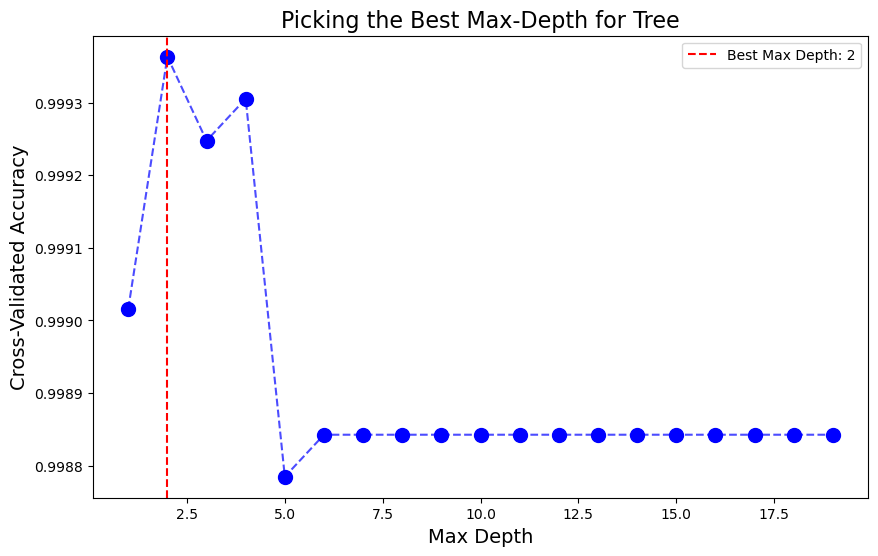

DecisionTreeClassifier(max_depth=2)

In [9]:
#Train Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_combined_filled, y_train_combined_filled)

#Find Max Depth for Tree
param_grid = {'max_depth': range(1, 20)}
tree_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_combined_filled, y_train_combined_filled)
best_max_depth = grid_search.best_params_['max_depth'] #Best Max_Depth
best_score = grid_search.best_score_

#Plot
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
depths = param_grid['max_depth']
plt.figure(figsize=(10, 6))
plt.scatter(depths, mean_test_scores, color='blue', s=100)
plt.plot(depths, mean_test_scores, color='blue', linestyle='--', alpha=0.7)
plt.xlabel('Max Depth', fontsize=14)
plt.ylabel('Cross-Validated Accuracy', fontsize=14)
plt.title('Picking the Best Max-Depth for Tree', fontsize=16)
best_max_depth = grid_search.best_params_['max_depth']
plt.axvline(x=best_max_depth, color='red', linestyle='--', label=f'Best Max Depth: {best_max_depth}')
plt.legend()
plt.show()

#Train Decision Tree model
tree_model = DecisionTreeClassifier(max_depth=best_max_depth)
tree_model.fit(X_train_combined_filled, y_train_combined_filled)


### Characterize Model Performance on the Testing Dataset
When it came to testing, I tested the Logisitic Regression Model to see how well it could classify players as a "MVP" or not via linear relationships depicted in their features. Furthermore, the Decision Tree model was trained to identify significant splits in the player stats to classify MVPs.

As you'd expect, I evaluated each model on their accuracy, precision, and recall.

In [10]:
#Evaluation of models
log_reg_preds_combined_filled = log_reg_model.predict(X_test_combined_filled)
log_reg_acc_combined_filled = accuracy_score(y_test_combined_filled, log_reg_preds_combined_filled)
log_reg_prec_combined_filled = precision_score(y_test_combined_filled, log_reg_preds_combined_filled)
log_reg_rec_combined_filled = recall_score(y_test_combined_filled, log_reg_preds_combined_filled)
tree_preds_combined_filled = tree_model.predict(X_test_combined_filled)
tree_acc_combined_filled = accuracy_score(y_test_combined_filled, tree_preds_combined_filled)
tree_prec_combined_filled = precision_score(y_test_combined_filled, tree_preds_combined_filled)
tree_rec_combined_filled = recall_score(y_test_combined_filled, tree_preds_combined_filled)

#RESULTS
log_reg_results_combined_filled = {
    "Accuracy": log_reg_acc_combined_filled,
    "Precision": log_reg_prec_combined_filled,
    "Recall": log_reg_rec_combined_filled
}

tree_results_combined_filled = {
    "Accuracy": tree_acc_combined_filled,
    "Precision": tree_prec_combined_filled,
    "Recall": tree_rec_combined_filled
}

print("Logistic Regression Results:", log_reg_results_combined_filled)
print("Decision Tree Results:", tree_results_combined_filled)

Logistic Regression Results: {'Accuracy': 0.9993057162693821, 'Precision': 0.5, 'Recall': 0.6666666666666666}
Decision Tree Results: {'Accuracy': 0.9993057162693821, 'Precision': 0.5, 'Recall': 0.6666666666666666}


Worried that the high accuracy might be a sign of overfitting, I turned to cross-validation to see how my models test as shown below.

In [11]:
#CV for log reg
log_reg_cv_scores = cross_val_score(log_reg_model, X_combined_filled, y_combined, cv = 5)

#CV for DT
tree_cv_scores = cross_val_score(tree_model, X_combined_filled, y_combined, cv = 7)

print(f"Mean CV Accuracy: {log_reg_cv_scores.mean()}")
print(f"Mean CV Accuracy: {tree_cv_scores.mean()}")

Mean CV Accuracy: 0.9993518839946172
Mean CV Accuracy: 0.9993518818489855


As shown above, these high Cross-Validation scores indicate a strong performance accross the selected features and suggest that the models are not showing signs overfitting and are rather predicting the MVP award winner with exceptional accuracy, moderately-high precision, and moderately-high-to-exceptional recall.

### Briefly Discuss Results
While both models made a good attempt at predicting the Most Valuable Player of a given MVP season (in the last 20 years), the Decision Tree Model was better in both Precision and Recall. I was curious about the measures that aided the Decision Tree Model in making it's predictions, this is how the model ranked features based on their importance:

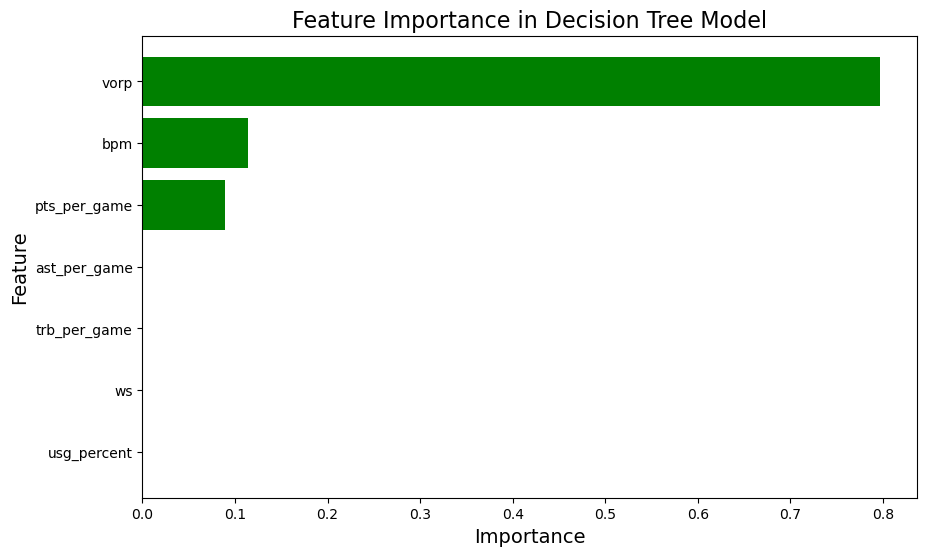

In [12]:
feature_importance = tree_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in Decision Tree Model', fontsize=16)
plt.gca().invert_yaxis()
plt.show()

It's clear that Value Over Replacement Player (vorp) was by far the largest signifier with Usage Percentage (usg_percent) and Points Per Game (pts_per_game) were minimal signifiers. Regardless of how accurate these models are, the NBA MVP is not guaranteed due to the likelihood of overfitting and the dynamic nature of future seasons. It is also woth noting that in my own time, I did play around with the number of seasons being considered and the further back I set these models, the more "randomness" involved since the criteria for this award has vastly changed, even in the last 5-10 years and is likely continue to change and adapt with more seasons to come.